In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, 
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

## Reading the data

In [2]:
#Reading and understanding the data
#link = "https://data.seattle.gov/api/views/tazs-3rd5/rows.csv?date=20231107&accessType=DOWNLOAD" 

#Reading
seattle_crime = pd.read_csv('SPD_Crime_Data__2008-Present_20231107.csv')

In [3]:
seattle_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085079 entries, 0 to 1085078
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Report Number           1085079 non-null  object 
 1   Offense ID              1085079 non-null  int64  
 2   Offense Start DateTime  1083570 non-null  object 
 3   Offense End DateTime    617085 non-null   object 
 4   Report DateTime         1085079 non-null  object 
 5   Group A B               1085079 non-null  object 
 6   Crime Against Category  1085079 non-null  object 
 7   Offense Parent Group    1085079 non-null  object 
 8   Offense                 1085079 non-null  object 
 9   Offense Code            1085079 non-null  object 
 10  Precinct                1085061 non-null  object 
 11  Sector                  1085063 non-null  object 
 12  Beat                    1085063 non-null  object 
 13  MCPP                    1085065 non-null  object 
 14  10

## Data Preprocessing

In [4]:
seattle_crime.isnull().sum()

Report Number                  0
Offense ID                     0
Offense Start DateTime      1509
Offense End DateTime      467994
Report DateTime                0
Group A B                      0
Crime Against Category         0
Offense Parent Group           0
Offense                        0
Offense Code                   0
Precinct                      18
Sector                        16
Beat                          16
MCPP                          14
100 Block Address          47544
Longitude                      0
Latitude                       0
dtype: int64

In [5]:
#Treating missing values
#Removing Offense End DateTime and 100 Block Address as we have other columns to support these info.
#Along removing other missing values
sc=seattle_crime.drop(['Offense End DateTime'], axis=1)
sc = sc.drop(['100 Block Address'],axis=1)
sc = sc.dropna()
sc.isnull().sum()

Report Number             0
Offense ID                0
Offense Start DateTime    0
Report DateTime           0
Group A B                 0
Crime Against Category    0
Offense Parent Group      0
Offense                   0
Offense Code              0
Precinct                  0
Sector                    0
Beat                      0
MCPP                      0
Longitude                 0
Latitude                  0
dtype: int64

In [6]:
#splitting start date and time
#copying the values to a new column 
sc['Offense DateTime'] = sc['Offense Start DateTime']
#converting to datetime datatype
sc['Offense Start DateTime'] = pd.to_datetime(sc['Offense Start DateTime'], format='%m/%d/%Y %I:%M:%S %p')
#fetching date ,year,month, time columns
sc['Offense Start Date'] = sc['Offense Start DateTime'].dt.date
sc['Offense Start Time'] = sc['Offense Start DateTime'].dt.time
sc['year']=sc['Offense Start DateTime'].dt.year
sc['month'] = sc['Offense Start DateTime'].dt.month
sc['weekday']=sc['Offense Start DateTime'].apply(lambda x: x.weekday())

In [7]:
#defining seasons and time of the day
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return "Invalid Month"
    
def categorize_time_of_day(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

In [8]:
#Fetching season column
sc.month=sc.month.astype(int)
sc['season'] = sc['month'].apply(get_season)
sc['timeofday'] = sc['Offense Start Time'].apply(categorize_time_of_day)

In [9]:
#considering required data from 2008 to 2022
filter_sc = sc[sc['year'] >= 2008]
filter_sc = filter_sc[filter_sc['year'] <= 2022]

In [10]:
filter_sc.shape

(1023690, 23)

## Modeling

In [11]:
grouped_data = filter_sc.groupby(['Offense Start Date','MCPP']).agg({'Offense ID': 'count'}).reset_index()

#Rename the count column if desired
grouped_data = grouped_data.rename(columns={'Offense ID': 'CrimeCount','Offense Start Date' : 'Date'})


In [12]:
grouped_data1 = filter_sc.groupby(['year','season','MCPP']).agg({'Offense ID': 'count'}).reset_index()

#Rename the count column if desired
grouped_data1 = grouped_data1.rename(columns={'Offense ID': 'CrimeCount'})


#grouped_data1['Season_Year']=grouped_data1['season'].astype(str) + '_' + grouped_data1['year']

#grouped_data1.drop(['year','season'], axis=1)
#grouped_data1


In [13]:
grouped_data3 = filter_sc.groupby(['year','MCPP']).agg({'Offense ID': 'count'}).reset_index()

#Rename the count column if desired
grouped_data3 = grouped_data3.rename(columns={'Offense ID': 'CrimeCount','year':'Year'})


In [14]:
df=grouped_data3.copy()

In [15]:
# Function to train ARIMA model for a specific locality
def train_arima_locality(locality_data):
    # Assuming order=(p, d, q) values are chosen based on model diagnostics
    model = ARIMA(locality_data['CrimeCount'], order=(1, 1, 1))
    fitted_model = model.fit()
    return fitted_model

# Function to forecast future years for a specific locality
def forecast_future_locality(model, start_year, end_year):
    future_years = np.arange(start_year, end_year + 1)
    forecast = model.get_forecast(steps=len(future_years))
    forecast_df = pd.DataFrame({'Year': future_years, 'ForecastedCrimeCount': forecast.predicted_mean.values})
    return forecast_df

# Function to evaluate the model on a testing set (optional)
def evaluate_model_locality(model, test_data):
    predictions = model.get_forecast(steps=len(test_data))
    mse = mean_squared_error(test_data['CrimeCount'], predictions.predicted_mean)
    rmse = sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse}')


In [16]:
# Specify the locality for which you want to train and forecast
target_locality = 'ALASKA JUNCTION'

# Filter data for the target locality
locality_data = df[df['MCPP'] == target_locality]

## Model 1

/Users/likithajagithyala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/likithajagithyala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/likithajagithyala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/likithajagithyala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


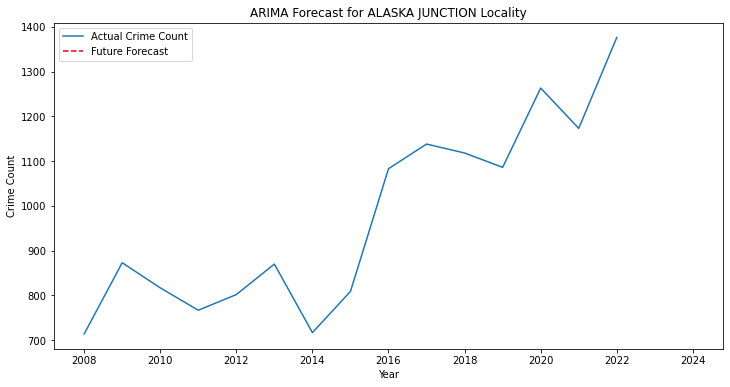

   Year  ForecastedCrimeCount
0  2024           1342.653203


In [17]:
# Train ARIMA model for the target locality
arima_model_locality = train_arima_locality(locality_data)

# Forecast future years for the target locality
start_year = locality_data['Year'].max() + 2
end_year = 2024  # Adjust based on how many future years you want to predict
future_forecast_locality = forecast_future_locality(arima_model_locality, start_year, end_year)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(locality_data['Year'], locality_data['CrimeCount'], label='Actual Crime Count')
plt.plot(future_forecast_locality['Year'], future_forecast_locality['ForecastedCrimeCount'], 
         label='Future Forecast', linestyle='dashed', color='red')
plt.title(f'ARIMA Forecast for {target_locality} Locality')
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

print(future_forecast_locality)

In [42]:
# Function to train and evaluate a regression model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, future_years):
    model.fit(X_train, y_train)
    
    # Make predictions for the train set
    y_pred_t = model.predict(X_train)

    # Make predictions for the test set
    y_pred = model.predict(X_test)

    print('Training data metrics')
    # Evaluate the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_train, y_pred_t)
    print(f'Mean Absolute Error (MAE): {mae}')
    rmse = round(mean_squared_error(y_train, y_pred_t, squared=False), 4)
    print(f'Root mean Squared Error (RMSE): {rmse}')
    r_squared = r2_score(y_train, y_pred_t)
    print(f'R-squared: {r_squared}')

    print('Test data metrics')
    # Evaluate the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # Evaluate the model using Mean Squared Error (MSE)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
    print(f'Root mean Squared Error (RMSE): {rmse}')

    # Calculate R-squared
    r_squared = r2_score(y_test, y_pred)
    print(f'R-squared: {r_squared}')

    # Forecast 
    future_predictions = model.predict(future_years)

    print("\nForecasted Crime Count (Future Years):")
    print(pd.DataFrame({'Year': future_years.flatten(), 'ForecastedCrimeCount': future_predictions}))

    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(locality_data['Year'], locality_data['CrimeCount'], label='Actual Crime Count', marker='o', linestyle='-', color='blue')
    plt.plot(X_test.values.flatten(), y_pred, label='Predicted Crime Count (Test Set)', marker='o', linestyle='--', color='orange')
    plt.plot(future_years.flatten(), future_predictions, label='Forecasted Crime Count for 2024', marker='o', linestyle='--', color='green')

    plt.title(f'Crime Count Forecasting for {target_locality} Locality ({model.__class__.__name__})')
    plt.xlabel('Year')
    plt.ylabel('Crime Count')
    plt.legend()
    plt.show()

    return model, y_pred

In [43]:
# Prepare the data
X = locality_data[['Year']]
y = locality_data['CrimeCount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

future_years = np.arange(locality_data['Year'].max() + 1, df['Year'].max() + 6).reshape(-1, 1)

## Linear Regression

Training data metrics
Mean Absolute Error (MAE): 83.3010667720276
Root mean Squared Error (RMSE): 103.1846
R-squared: 0.7583338973852873
Test data metrics
Mean Absolute Error (MAE): 63.22902673514909
Root mean Squared Error (RMSE): 64.6783
R-squared: 0.882661838036287

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023           1317.488740
1  2024           1361.087317
2  2025           1404.685895
3  2026           1448.284473
4  2027           1491.883050


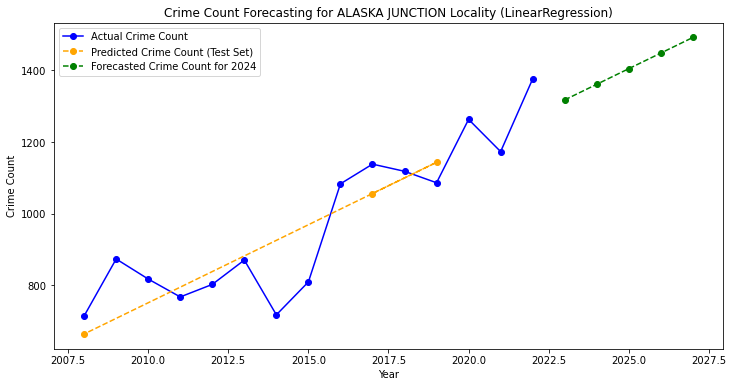

In [44]:
#Linear Regression
linear_model, linear_predictions = train_and_evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, future_years)

## Random forest

Training data metrics
Mean Absolute Error (MAE): 31.289166666666677
Root mean Squared Error (RMSE): 38.248
R-squared: 0.9667950008448672
Test data metrics
Mean Absolute Error (MAE): 90.61666666666667
Root mean Squared Error (RMSE): 95.9997
R-squared: 0.7414997123391841

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023               1308.79
1  2024               1308.79
2  2025               1308.79
3  2026               1308.79
4  2027               1308.79


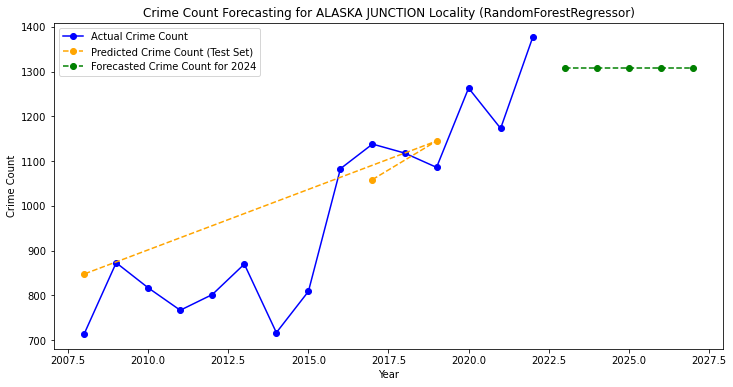

In [45]:
#Random Forest Regressor 
rfr_model, rfr_predictions = train_and_evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, future_years)

## support vector 

Training data metrics
Mean Absolute Error (MAE): 172.9352162107823
Root mean Squared Error (RMSE): 229.5265
R-squared: -0.19578196106643353
Test data metrics
Mean Absolute Error (MAE): 210.13606529382756
Root mean Squared Error (RMSE): 214.3486
R-squared: -0.28873202386712515

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023            876.992728
1  2024            876.329115
2  2025            875.700096
3  2026            875.191257
4  2027            874.832827


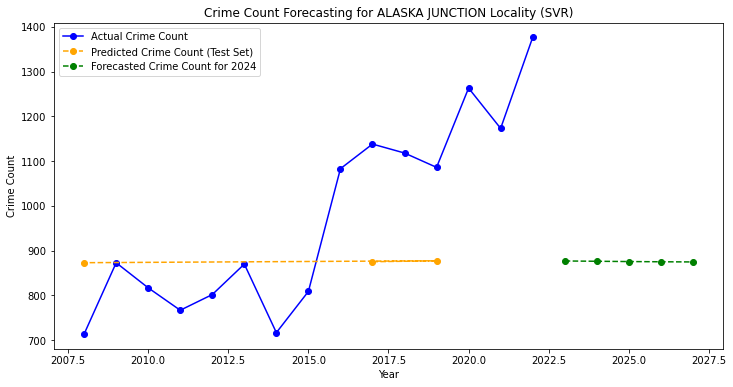

In [46]:
#Support Vector Regressor
svr_model, svr_predictions = train_and_evaluate_model(SVR(kernel='rbf'), X_train, X_test, y_train, y_test, future_years)


## Gradient Boost

Training data metrics
Mean Absolute Error (MAE): 0.2324525362353332
Root mean Squared Error (RMSE): 0.2927
R-squared: 0.999998055757212
Test data metrics
Mean Absolute Error (MAE): 81.92482788345505
Root mean Squared Error (RMSE): 98.7632
R-squared: 0.7264028697195088

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023           1375.820292
1  2024           1375.820292
2  2025           1375.820292
3  2026           1375.820292
4  2027           1375.820292


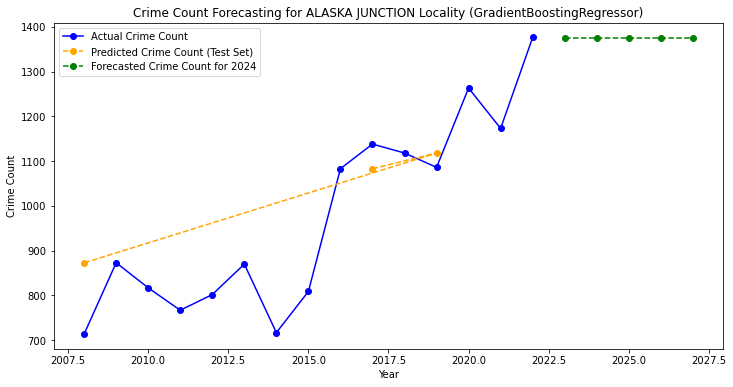

In [48]:
#gradient boost regressor
gbr_model, gbr_predictions = train_and_evaluate_model(GradientBoostingRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, future_years)


## Lasso Regression

Training data metrics
Mean Absolute Error (MAE): 83.30533386013364
Root mean Squared Error (RMSE): 103.1846
R-squared: 0.7583338844714087
Test data metrics
Mean Absolute Error (MAE): 63.21180034242085
Root mean Squared Error (RMSE): 64.6659
R-squared: 0.8827069150790072

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023           1317.443698
1  2024           1361.036586
2  2025           1404.629475
3  2026           1448.222363
4  2027           1491.815251


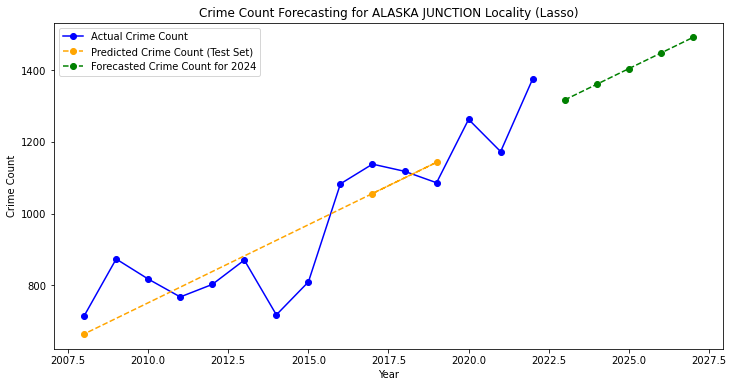

In [49]:
# Lasso Regression
lasso_model, lasso_predictions = train_and_evaluate_model(Lasso(alpha=0.1), X_train, X_test, y_train, y_test, future_years)


## Ridge Regression

Training data metrics
Mean Absolute Error (MAE): 83.31656267277383
Root mean Squared Error (RMSE): 103.1846
R-squared: 0.7583337270804577
Test data metrics
Mean Absolute Error (MAE): 63.166469209914794
Root mean Squared Error (RMSE): 64.6333
R-squared: 0.8828253348989012

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023           1317.325172
1  2024           1360.903088
2  2025           1404.481005
3  2026           1448.058921
4  2027           1491.636838


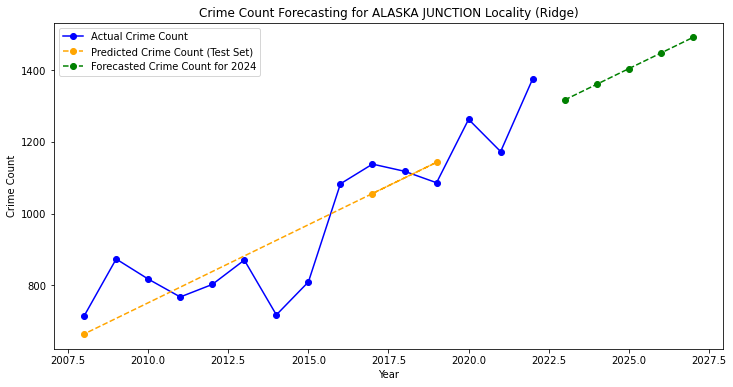

In [50]:
# Ridge Regression
ridge_model, ridge_predictions = train_and_evaluate_model(Ridge(alpha=0.1), X_train, X_test, y_train, y_test, future_years)


## Elastic Net

Training data metrics
Mean Absolute Error (MAE): 83.39594988574754
Root mean Squared Error (RMSE): 103.1859
R-squared: 0.7583275122345015
Test data metrics
Mean Absolute Error (MAE): 62.8459800908798
Root mean Squared Error (RMSE): 64.4042
R-squared: 0.8836542848725866

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023           1316.487196
1  2024           1359.959262
2  2025           1403.431329
3  2026           1446.903396
4  2027           1490.375463


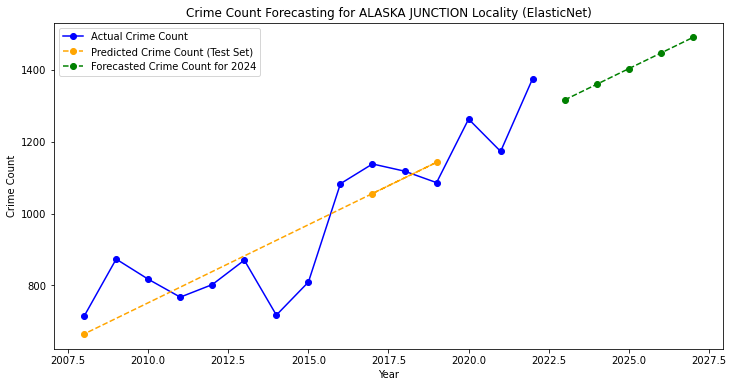

In [51]:
# ElasticNet Regression
elasticnet_model, elasticnet_predictions = train_and_evaluate_model(ElasticNet(alpha=0.1, l1_ratio=0.5), X_train, X_test, y_train, y_test, future_years)


## K-NN

Training data metrics
Mean Absolute Error (MAE): 70.11666666666667
Root mean Squared Error (RMSE): 89.2269
R-squared: 0.8192919003712371
Test data metrics
Mean Absolute Error (MAE): 122.79999999999995
Root mean Squared Error (RMSE): 123.4164
R-squared: 0.5727647850802835

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023                1202.6
1  2024                1202.6
2  2025                1202.6
3  2026                1202.6
4  2027                1202.6


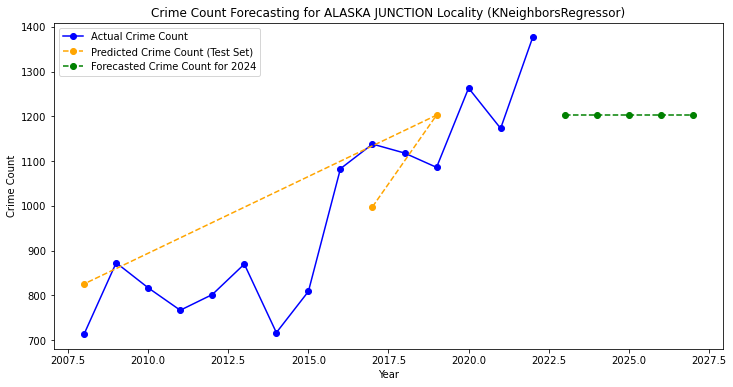

In [53]:
# K-Nearest Neighbors Regression
knn_model, knn_predictions = train_and_evaluate_model(KNeighborsRegressor(n_neighbors=5), X_train, X_test, y_train, y_test, future_years)


## XGBoost

Training data metrics
Mean Absolute Error (MAE): 0.0009816487630208333
Root mean Squared Error (RMSE): 0.0011
R-squared: 0.9999999999707083
Test data metrics
Mean Absolute Error (MAE): 82.0003662109375
Root mean Squared Error (RMSE): 98.8769
R-squared: 0.7257726183430031

Forecasted Crime Count (Future Years):
   Year  ForecastedCrimeCount
0  2023           1375.998779
1  2024           1375.998779
2  2025           1375.998779
3  2026           1375.998779
4  2027           1375.998779


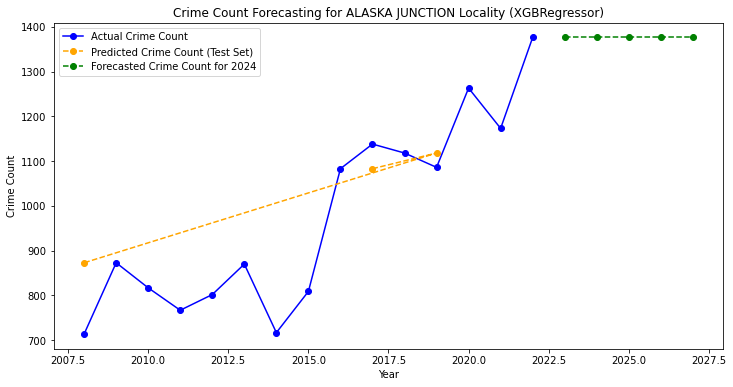

In [54]:
# XGBoost Regression
xgb_model, xgb_predictions = train_and_evaluate_model(XGBRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, future_years)


## Summary

                     Modeling on Crime count forecast for future year and their performance evaluation 

|    Model Name     | RMSE(Train) |  RMSE(Test) | R^2(Train) |  R^2(Test) |
| :---------------- | :---------: | :---------: | :--------: | ---------: |
| Linear Regression |    103.18   |   64.6783   |   0.7583   |   0.8826   |            
|   Random Forest   |    38.248   |   95.9997   |   0.9668   |   0.7415   | 
|  Support Vector   |    229.52   |   214.348   |  -0.1957   |  -0.2887   |
| Gradient Boosting |    0.2927   |   98.7632   |   0.9999   |   0.7264   |
| Lasso Regression  |    103.18   |   64.6659   |   0.7583   |   0.8827   |
| Ridge Regression  |    103.18   |   64.6333   |   0.7583   |   0.8828   |
|    Elastic Net    |    103.18   |   64.6333   |   0.7583   |   0.8836   |
|       K-NN        |    89.2269  |   123.416   |   0.8192   |   0.5727   |
|      XGBoost      |    0.0011   |   98.8769   |   0.9999   |   0.7257   |